In [33]:
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
import time

In [26]:
# loading training set features
f = open("Datasets/train_set_features.pkl", "rb")
train_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length 
features_STDs = np.std(a=train_set_features2, axis=0)
train_set_features = train_set_features2[:, features_STDs > 52.3]

# changing the range of data between 0 and 1
train_set_features = np.divide(train_set_features, train_set_features.max())

# loading training set labels
f = open("Datasets/train_set_labels.pkl", "rb")
train_set_labels = pickle.load(f)
f.close()

# ------------
# loading test set features
f = open("Datasets/test_set_features.pkl", "rb")
test_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length 
features_STDs = np.std(a=test_set_features2, axis=0)
test_set_features = test_set_features2[:, features_STDs > 48]

# changing the range of data between 0 and 1
test_set_features = np.divide(test_set_features, test_set_features.max())

# loading test set labels
f = open("Datasets/test_set_labels.pkl", "rb")
test_set_labels = pickle.load(f)
f.close()

# ------------
# preparing our training and test sets - joining datasets and lables
train_set = []
test_set = []

for i in range(len(train_set_features)):
    label = np.array([0,0,0,0])
    label[int(train_set_labels[i])] = 1
    label = label.reshape(4,1)
    train_set.append((train_set_features[i].reshape(102,1), label))
    

for i in range(len(test_set_features)):
    label = np.array([0,0,0,0])
    label[int(test_set_labels[i])] = 1
    label = label.reshape(4,1)
    test_set.append((test_set_features[i].reshape(102,1), label))

# shuffle
random.shuffle(train_set)
random.shuffle(test_set)

In [27]:
def sigmoid(z):
    return 1/(1 + np.exp(-z, dtype=np.longdouble))

def d_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [56]:
class MLP:
    
    weights: list[np.ndarray]
    biases: list[np.ndarray]
    
    def __init__(self, layers_size: list[tuple[int, int]], learning_rate=1):
        self.weights = []
        self.biases = []
        self.learning_rate = learning_rate
        
        for size in layers_size:
            self.weights.append(np.random.normal(size=size))
            self.biases.append(np.zeros((1, size[1])).astype(np.longdouble))
        
        self.layers_number = len(self.weights)

    def feed(self, data):
        W = self.weights
        b = self.biases
        
        result = []
        o = sigmoid(W[0].T.dot(data) + b[0].T)
        result.append(o)
        for i in range(1, self.layers_number):
            o = sigmoid(W[i].T.dot(o) + b[i].T)
            result.append(o)
        return result
    
    def train(self, x, y, batch_size=10, epoch_number=5, validation=0.2):
        w = self.weights
        b = self.biases
        
        # Seperating validation and train
        seperator_index = int(validation * x.shape[1])
        x_valid = x[:, :seperator_index]
        y_valid = y[:, :seperator_index]
        x_train = x[:, seperator_index:]
        y_train = y[:, seperator_index:]
        
        # Performing learning algorithm
        validation_values = []
        for i in range(epoch_number):
            cost = 0
            for j in range(0, x.shape[1], batch_size):
                data = x_train[:, j:j+batch_size]       # A batch of inputs
                y_ex = y_train[:, j:j+batch_size]       # Expected Output
                out = self.feed(data)             # Outputs of each layer for the given batch
                
                m = data.shape[1]
                if m == 0:
                    continue
                
                # Back Propagation Phase
                d_loss = self.d_loss_function(out[2], y_ex)
                cost += np.sum(d_loss * d_loss) / (2*m)
                e2 = d_loss * d_sigmoid(out[2])
                e1 = w[2].dot(e2) * d_sigmoid(out[1])
                e0 = w[1].dot(e1) * d_sigmoid(out[0])
                
                w[0] -= self.learning_rate * (1/m) * data.dot(e0.T)
                w[1] -= self.learning_rate * (1/m) * out[0].dot(e1.T)
                w[2] -= self.learning_rate * (1/m) * out[1].dot(e2.T)
                
                b[0] -= self.learning_rate * (1/m) * np.sum(e0.T, axis=0)
                b[1] -= self.learning_rate * (1/m) * np.sum(e1.T, axis=0)
                b[2] -= self.learning_rate * (1/m) * np.sum(e2.T, axis=0)
            validation_values.append(cost)
            
        plt.plot(range(epoch_number), validation_values)
    
    def test(self, x, y):
        out = self.feed(x)
        maximum = np.argmax(out[-1], axis=0)
        equality = (maximum == np.argmax(y, axis=0)).astype('int')
        return sum(equality) / y.shape[1]
    
    def d_loss_function(self, output, y_expected, function_type='SSE'):
        if function_type == 'SSE':
            return output - y_expected
        


In [29]:
# Seperate x and y of train set
x_train = np.column_stack([i[0] for i in train_set])
y_train = np.column_stack([i[1] for i in train_set])

# Seperate x and y of test set
x_test = np.column_stack([i[0] for i in test_set])
y_test = np.column_stack([i[1] for i in test_set])

<h1 align="center"> Train by 200 items </h1>

Here we train our model by 200 items of train set and finally we will witness that it has accuracy around 0.95.

Accuracy before train: 0.24
Training finished with in 0.2496039867401123 s
Accuracy after train: 0.9984894259818731
Train Set Accuracy: 0.98


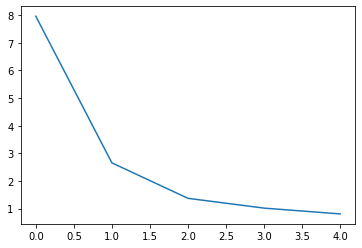

In [58]:
# Create neural network object
mlp = MLP([(102, 150), (150, 60), (60, 4)])

# Using 200 items of test set to see the accuracy for Phase 1
print('Accuracy before train:', mlp.test(x_test[:, :200], y_test[:, :200]))

# Training the model
tik = time.time()
mlp.train(x_train[:, :200], y_train[:, :200])
tok = time.time()
print('Training finished within', tok - tik, 's')

# Using whole test set to see the accuracy
print('Accuracy after train:', mlp.test(x_test, y_test))

print('Train Set Accuracy:', mlp.test(x_train[:, :200], y_train[:, :200]))

<h1 align="center"> Train and Test with all of datasets </h1>

In this part first we make a numpy array of the train_set and test_set. After that we seperate 200 items of test set to see the accuray of model. It is close to 0.25 normally. Then we train an we will see the accuracy rises up to 1.0.

Accuracy before train: 0.24
Training finished with in 3.635380506515503 s
Accuracy after train: 1.0
Train Set Accuracy: 1.0


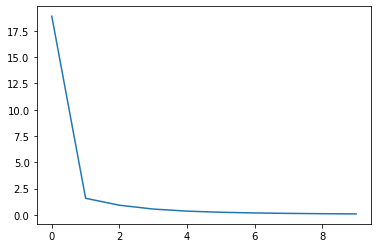

In [59]:
# Create neural network object
mlp = MLP([(102, 150), (150, 60), (60, 4)])

# Using 200 items of test set to see the accuracy for Phase 1
print('Accuracy before train:', mlp.test(x_test[:, :200], y_test[:, :200]))

# Training the model
tik = time.time()
mlp.train(x_train, y_train, epoch_number=10)
tok = time.time()
print('Training finished within', tok - tik, 's')

# Using whole test set to see the accuracy
print('Accuracy after train:', mlp.test(x_test, y_test))

print('Train Set Accuracy:', mlp.test(x_train, y_train))

<h1 align="center"> Analyzing Hyperparameters </h1>

Here we do some changes on hyper parameters.

## Learning rate:

By setting learning rate to 0.1 we see the cost gets very low decending and final accuracy is less than when it was 1.
By setting learning rate to 50 we see the final accuracy will become less than when it was 1. Additionally, We have oscillation on cost graph.
So I guess best value for learning rate is **between 1 and 30**.

Accuracy before train: 0.235
Training finished with in 3.627040147781372 s
Accuracy after train: 0.9290030211480362
Train Set Accuracy: 0.9994903160040775


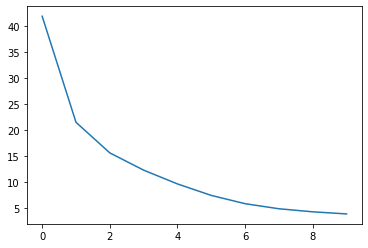

In [57]:
# Learning rate is set to 0.1
mlp = MLP([(102, 150), (150, 60), (60, 4)], learning_rate=0.1)

# Training the model
tik = time.time()
mlp.train(x_train, y_train, epoch_number=10)
tok = time.time()
print('Training finished within', tok - tik, 's')

# Using whole test set to see the accuracy
print('Accuracy after train:', mlp.test(x_test, y_test))
print('Train Set Accuracy:', mlp.test(x_train, y_train))

/tmp/ipykernel_53293/3152129171.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z, dtype=np.longdouble))


Training finished within 3.39512038230896 s
Accuracy after train: 0.9954682779456193
Train Set Accuracy: 0.9984709480122325


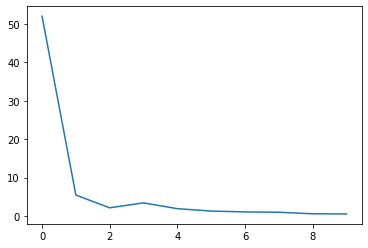

In [68]:
# Learning rate is set to 50
mlp = MLP([(102, 150), (150, 60), (60, 4)], learning_rate=50)

# Training the model
tik = time.time()
mlp.train(x_train, y_train, epoch_number=10)
tok = time.time()
print('Training finished within', tok - tik, 's')

# Using whole test set to see the accuracy
print('Accuracy after train:', mlp.test(x_test, y_test))
print('Train Set Accuracy:', mlp.test(x_train, y_train))

## Batch size:

Increasing batch size to get more than 10 makes the graph decending slower while decreasing its size makes it decending faster. So i guess best size for batch is **10 or less**.

Training finished within 5.679636240005493 s
Accuracy after train: 1.0
Train Set Accuracy: 1.0


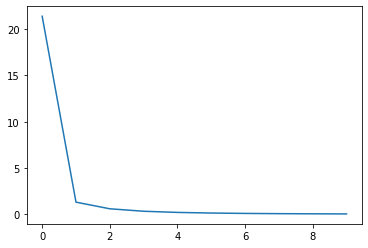

In [72]:
mlp = MLP([(102, 150), (150, 60), (60, 4)])

# Training the model
tik = time.time()
mlp.train(x_train, y_train, batch_size=4, epoch_number=10)
tok = time.time()
print('Training finished within', tok - tik, 's')

# Using whole test set to see the accuracy
print('Accuracy after train:', mlp.test(x_test, y_test))
print('Train Set Accuracy:', mlp.test(x_train, y_train))

Training finished within 4.734931945800781 s
Accuracy after train: 1.0
Train Set Accuracy: 0.9836901121304791


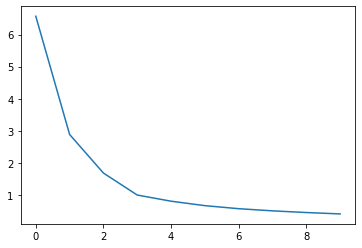

In [73]:
mlp = MLP([(102, 150), (150, 60), (60, 4)])

# Training the model
tik = time.time()
mlp.train(x_train, y_train, batch_size=100, epoch_number=10)
tok = time.time()
print('Training finished within', tok - tik, 's')

# Using whole test set to see the accuracy
print('Accuracy after train:', mlp.test(x_test, y_test))
print('Train Set Accuracy:', mlp.test(x_train, y_train))

## Epoch:

Because of the similarity we had in datasets images, changing of epoch does not change any thing. The cost gets to zero very soon at the 2nd epoch. **I Guess 10 is best value**.

Training finished within 7.222463369369507 s
Accuracy after train: 1.0
Train Set Accuracy: 1.0


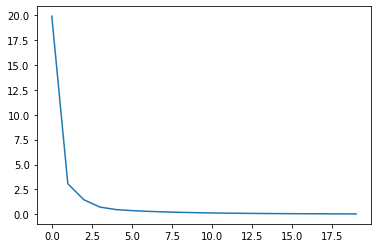

In [76]:
mlp = MLP([(102, 150), (150, 60), (60, 4)])

# Training the model
tik = time.time()
mlp.train(x_train, y_train, batch_size=10, epoch_number=20)
tok = time.time()
print('Training finished within', tok - tik, 's')

# Using whole test set to see the accuracy
print('Accuracy after train:', mlp.test(x_test, y_test))
print('Train Set Accuracy:', mlp.test(x_train, y_train))